# Processing Big Data - Data profiling

© Explore Data Science Academy

## Honour Code
I **KUSASALETHU**, **SITHOLE**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).
    Non-compliance with the honour code constitutes a material breach of contract.

## Context

Having completed the first step - data ingestion, the data now needs to be thoroughly prepared so that it is readable, reliable and robust. As the Data Engineer in the team, this will be your responsibility. The Data Scientists are looking to you to clean this data so that model development and deployment become seamless when the data is used in a production environment. Having completed your Data Engineering course recently, your manager Gnissecorp Atadgid, asks you to create data summaries and perform checks using the six dimensions of data quality.

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://github.com/Explore-AI/Pictures/raw/master/data_engineering/transform/predict/DataQuality.jpg"
     alt="Data Quality"
     style="float: center; padding-bottom=0.5em"
     width=100%/>
     <p><em>Figure 1. Six dimensions of data quality</em></p>
</div>

## Import libraries
Below we import the libraries required to complete this section of the predict.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

Remember that we need a `SparkContext` and `SparkSession` to interface with Spark.
We will mostly be using the `SparkContext` to interact with RDDs 
and the `SparkSession` to interface with Python objects.

> ℹ️ **Instructions** ℹ️
>
>Initialise a new **Spark Context** and **Session** that you will use to interface with Spark.

In [2]:
#Initialize spark context and session
sc = SparkContext()
spark = SparkSession(sc)

## Parquet files
In the previous section of the predict, you generated parquet files to your local directory. You will be making use of these files to continue with this section of the predict. Please make sure that your parquet files are specifically for the year **1962**. Any other year used outside of **1962** will produce incorrect answers and have a negative impact on your overall predict mark.

> ℹ️ **Instructions** ℹ️
>
> Read the parquet files stored in your directory for the year **1962** into a Spark DataFrame.

In [3]:
#Read stocks parquet files into spark dataframe
stocks_df = spark.read.parquet(r"data\processed_data\1962\ingested_data")
stocks_df.show()

+-------------------+-----------+-----------+----------+-----------+------------+---------+-----+
|               date|       open|       high|       low|      close|   adj_close|   volume|stock|
+-------------------+-----------+-----------+----------+-----------+------------+---------+-----+
|1962-02-19 00:00:00|    5.83929|   5.907375|   5.83929|    5.86332|   1.3863293|  29900.0|   AA|
|1962-02-19 00:00:00|   5.481634|   5.528486|  5.481634|  5.5167727|   1.2804527|  32000.0| ARNC|
|1962-02-19 00:00:00|  0.9074074| 0.91563785|0.89917696|  0.9032922|  0.16141544| 619400.0|   BA|
|1962-02-19 00:00:00|  1.6770834|  1.6927084| 1.6614584|  1.6770834|   0.1440587| 170400.0|  CAT|
|1962-02-19 00:00:00|        0.0|   3.578869|      20.0|   3.549107| 0.056501225| 273600.0|  CVX|
|1962-02-19 00:00:00|0.099767394|0.099767394|0.09820853| 0.09820853| 0.037543412| 817400.0|  DIS|
|1962-02-19 00:00:00|        0.0|    29.9375|     29.75|    29.9375|  0.49964145|   1600.0|  DTE|
|1962-02-19 00:00:00

## Metadata 

Metadata is data containing additional information about the data itself. In the cloud storage, there is a metadata file called [`symbols_valid_meta.csv`](https://processing-big-data-predict-stocks-data.s3.eu-west-1.amazonaws.com/symbols_valid_meta.csv) that is collocated with the stock market data. You will need to download this to use when performing your data quality checks.

> ℹ️ **Instructions** ℹ️
>
> Download the metadata from the S3 bucket and read it into a Spark DataFrame.

In [4]:
#Read stocks csv files into spark dataframe
metadata_df = spark.read.csv(r"data\symbols_valid_meta.csv", header=True)
metadata_df.show()


+-------------+------+--------------------+----------------+---------------+---+--------------+----------+----------------+----------+-------------+----------+
|Nasdaq Traded|Symbol|       Security Name|Listing Exchange|Market Category|ETF|Round Lot Size|Test Issue|Financial Status|CQS Symbol|NASDAQ Symbol|NextShares|
+-------------+------+--------------------+----------------+---------------+---+--------------+----------+----------------+----------+-------------+----------+
|            Y|     A|Agilent Technolog...|               N|               |  N|         100.0|         N|            NULL|         A|            A|         N|
|            Y|    AA|Alcoa Corporation...|               N|               |  N|         100.0|         N|            NULL|        AA|           AA|         N|
|            Y|  AAAU|Perth Mint Physic...|               P|               |  Y|         100.0|         N|            NULL|      AAAU|         AAAU|         N|
|            Y|  AACG|ATA Creativity Gl.

## Data Accuracy
Data accuracy is the degree to which data correctly describes a "real world" object or event.

It is important to do checks to determine the basic integrity of the dataset; do the values fall within expected ranges?

Most of the possible errors relating to data accuracy can occur at collection time. In our case, it is not possible to test the collection time accuracy, so we have to infer from ranges and summary statistics. Here you need to look closely at each field to see if its values make sense, with no strange surprises.

In assessing accuracy, it is important to look into precision as well. Do you need seven decimals, or will one or two suffice?

- **Measured by**: The degree to which the data mirrors the characteristics of the real-world object or objects it represents;
- **Units**: The percentage of data entries that pass the data accuracy rules;
- **Related to**: Validity, Uniqueness, Consistency.

> ℹ️ **Instructions** ℹ️
>
> Generate summary statistics to explore your data. Make sure you understand the ranges, means, extremums, and deviations found in the data set.

In [5]:
#Generate summary statistics
stocks_df.describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----+
|summary|              open|              high|               low|            close|        adj_close|           volume|stock|
+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----+
|  count|              5106|              5106|              5064|             5106|             5085|             5085| 5106|
|   mean|1.0904873526012002|16.757624946793637|15.728619917198033|16.64199179044607|5.986642513535306|540930.2458210423| NULL|
| stddev|  2.36445352530491| 53.91407348193546| 51.32292289814399|53.54677139900802|24.64637054715319|864596.2440525505| NULL|
|    min|               0.0|               0.0|       0.052377883|      0.053624976|     4.0381454E-7|              0.0|   AA|
|    max|              20.0|             287.5|             282.5|            285.0|        127.45936|        1

> ℹ️ **Instructions** ℹ️
>
> Generate histograms for the six numerical attributes found in the data to understand the distribution of values.
>
>*You may use as many coding cells as necessary.*

['open', 'high', 'low', 'close', 'adj_close', 'volume']


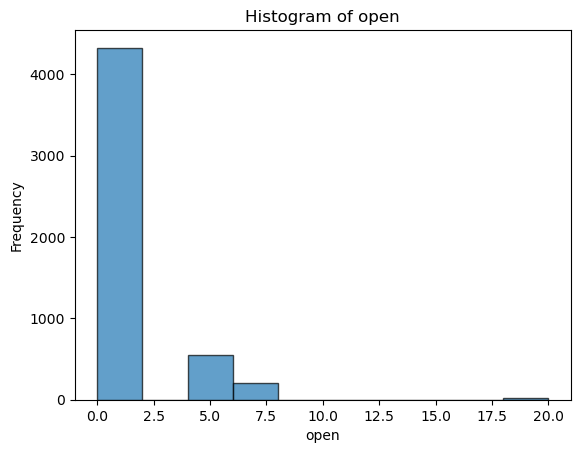

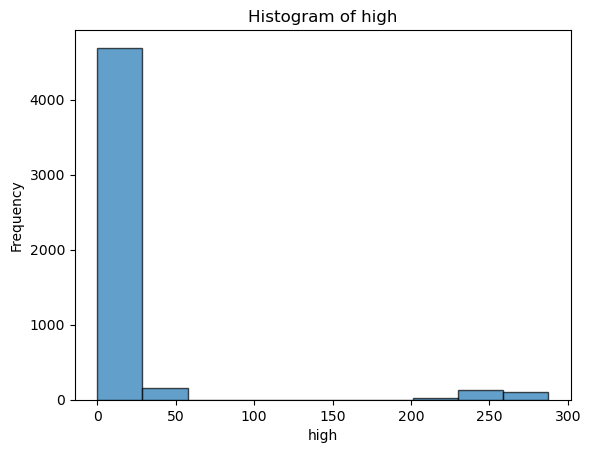

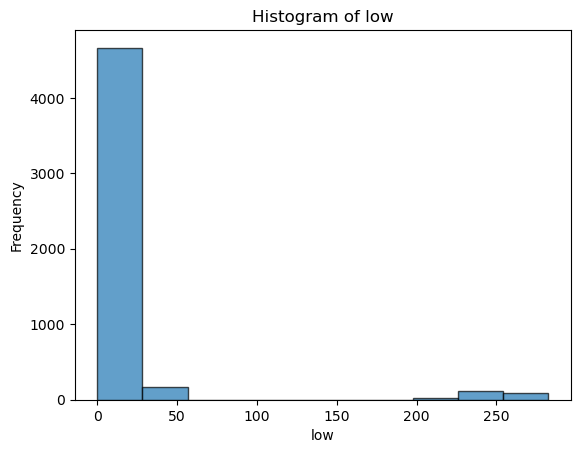

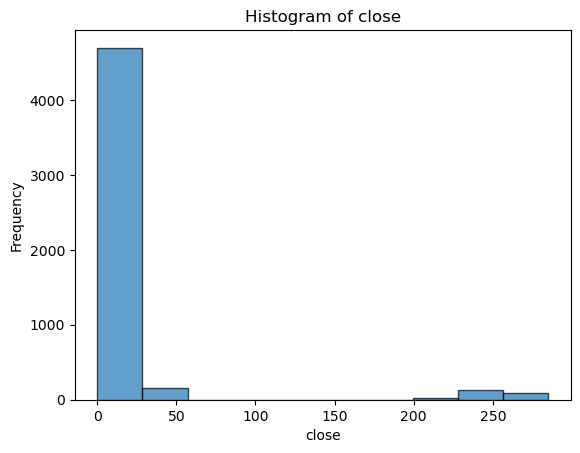

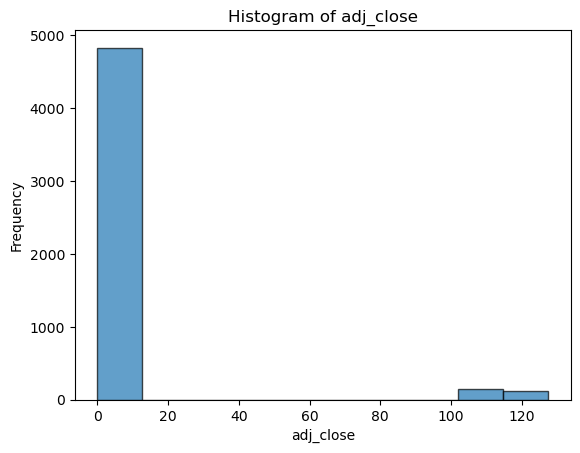

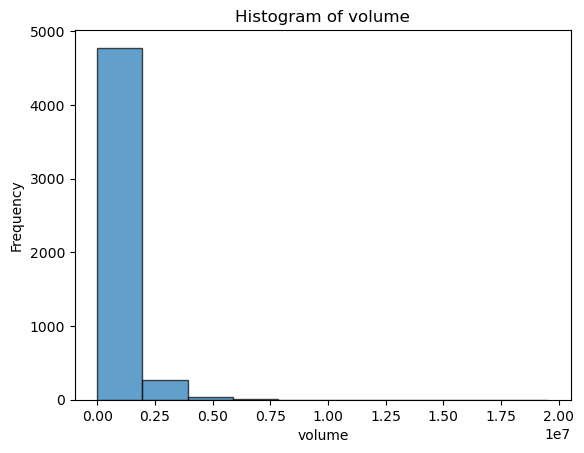

In [6]:
#Histogram for distribution of the six numeral fields

#Numerical fields
numerical_fields = [field[0] for field in stocks_df.dtypes if field[1] == 'float' or field[1] == 'integer']
print(numerical_fields)

# Create a histogram for each numerical field
for field in numerical_fields:
    # Get the data for the field
    data = stocks_df.select(field).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
    
    # Plot the histogram
    plt.figure()
    plt.hist(data, bins=10, edgecolor='k', alpha=0.7)
    plt.title(f"Histogram of {field}")
    plt.xlabel(field)
    plt.ylabel("Frequency")
    plt.show()

> ℹ️ **Instructions** ℹ️
>
> Investigate the **open** column to identify stocks that have open values greater than 2, and note any anomalies that you find in the data.
>
>*You may use as many coding cells as necessary.*

In [7]:
#Investigate open field data
stocks_df.filter(F.col("open") > 2).groupBy(F.col("stock")).agg(F.max(F.col("open")),F.count(F.col("open"))).sort("max(open)", ascending=False).show()

+-----+---------+-----------+
|stock|max(open)|count(open)|
+-----+---------+-----------+
|   PG|     20.0|         23|
|  IBM| 7.713333|        252|
|   AA| 6.764445|        252|
| ARNC| 6.360101|        231|
|ARNCA| 5.387931|         21|
+-----+---------+-----------+



In [8]:
#Investigate open field data
stocks_df.filter(F.col("open") > 2).groupBy(F.col("stock")).agg(F.min(F.col("open")),F.count(F.col("open"))).sort("min(open)", ascending=False).show()

+-----+---------+-----------+
|stock|min(open)|count(open)|
+-----+---------+-----------+
|   PG|     20.0|         23|
|ARNCA|4.9194155|         21|
|   AA|  4.65381|        252|
| ARNC|4.3806224|        231|
|  IBM|     4.08|        252|
+-----+---------+-----------+



In [9]:
# Looking at the PG stock
stocks_df.filter((F.col("open") > 2) & (F.col("stock") == "PG")).groupBy(F.col("stock"), F.col("open")).count().show()

+-----+----+-----+
|stock|open|count|
+-----+----+-----+
|   PG|20.0|   23|
+-----+----+-----+



 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1. Only 5 stocks have open values that are greater than 2
 2. The stock PG has an unusually high open value of 20 - and all of those values are exactly the value 20.
 3. The open value of the remaining 4 stocks ranges between 4 and 8. Nothing between 2 and 4.
 

> ℹ️ **Instructions** ℹ️
>
> Investigate **high**, **low**, **close**, and **adj_close** to determine if any stocks may be deviating from the normal ranges of the data set. Note down the stock(s) that you come across.
>
>*You may use as many coding cells as necessary.*

In [10]:
#Looking at the high field data
stocks_df.filter(F.col("high") > 60).groupby(F.col("stock")).agg(F.max(F.col("high")),F.count(F.col("high"))).sort(F.col("count(high)"), ascending=False).show()

+-----+---------+-----------+
|stock|max(high)|count(high)|
+-----+---------+-----------+
|  NAV|    287.5|        252|
+-----+---------+-----------+



In [11]:
#Looking at the high field data
stocks_df.filter(F.col("high") > 60).groupby(F.col("stock")).agg(F.min(F.col("high")),F.count(F.col("high"))).sort(F.col("count(high)"), ascending=False).show()

+-----+---------+-----------+
|stock|min(high)|count(high)|
+-----+---------+-----------+
|  NAV|  221.875|        252|
+-----+---------+-----------+



In [12]:
#Looking at the high field data
stocks_df.filter(F.col("high") > 60).groupby(F.col("stock"),F.col("high")).agg(F.count(F.col("high"))).sort(F.col("count(high)"), ascending=False).show()

+-----+-------+-----------+
|stock|   high|count(high)|
+-----+-------+-----------+
|  NAV|234.375|         13|
|  NAV|231.875|         10|
|  NAV| 231.25|          8|
|  NAV|249.375|          6|
|  NAV|244.375|          6|
|  NAV|  262.5|          6|
|  NAV|  230.0|          6|
|  NAV|  235.0|          6|
|  NAV|  247.5|          6|
|  NAV|  265.0|          6|
|  NAV| 276.25|          6|
|  NAV|274.375|          5|
|  NAV|269.375|          5|
|  NAV|239.375|          5|
|  NAV| 248.75|          5|
|  NAV|  232.5|          5|
|  NAV| 228.75|          4|
|  NAV|265.625|          4|
|  NAV|268.125|          4|
|  NAV|264.375|          4|
+-----+-------+-----------+
only showing top 20 rows



In [13]:
#Looking at the low field data
stocks_df.filter(F.col("low") > 60).groupby(F.col("stock")).agg(F.max(F.col("low")),F.count(F.col("low"))).sort(F.col("count(low)"), ascending=False).show()

+-----+--------+----------+
|stock|max(low)|count(low)|
+-----+--------+----------+
|  NAV|   282.5|       232|
+-----+--------+----------+



In [14]:
#Looking at the low field data
stocks_df.filter(F.col("low") > 60).groupby(F.col("stock")).agg(F.min(F.col("low")),F.count(F.col("low"))).sort(F.col("count(low)"), ascending=False).show()

+-----+--------+----------+
|stock|min(low)|count(low)|
+-----+--------+----------+
|  NAV|   217.5|       232|
+-----+--------+----------+



In [15]:
#Looking at the low field data
stocks_df.filter(F.col("low") > 60).groupby(F.col("stock"),F.col("low")).agg(F.count(F.col("low"))).sort(F.col("count(low)"), ascending=False).show()

+-----+-------+----------+
|stock|    low|count(low)|
+-----+-------+----------+
|  NAV|  230.0|         8|
|  NAV|230.625|         8|
|  NAV|228.125|         8|
|  NAV| 226.25|         7|
|  NAV|  227.5|         7|
|  NAV|233.125|         7|
|  NAV|225.625|         6|
|  NAV|276.875|         6|
|  NAV| 261.25|         5|
|  NAV|  232.5|         5|
|  NAV|265.625|         4|
|  NAV|  272.5|         4|
|  NAV|270.625|         4|
|  NAV|  252.5|         4|
|  NAV|  260.0|         4|
|  NAV| 221.25|         4|
|  NAV| 243.75|         4|
|  NAV| 231.25|         4|
|  NAV|260.625|         4|
|  NAV|  265.0|         4|
+-----+-------+----------+
only showing top 20 rows



In [16]:
#Looking at the close field data
stocks_df.filter(F.col("close") > 60).groupby(F.col("stock")).agg(F.max(F.col("close")),F.count(F.col("close"))).sort(F.col("count(close)"), ascending=False).show()

+-----+----------+------------+
|stock|max(close)|count(close)|
+-----+----------+------------+
|  NAV|     285.0|         252|
+-----+----------+------------+



In [17]:
#Looking at the close field data
stocks_df.filter(F.col("close") > 60).groupby(F.col("stock")).agg(F.min(F.col("close")),F.count(F.col("close"))).sort(F.col("count(close)"), ascending=False).show()

+-----+----------+------------+
|stock|min(close)|count(close)|
+-----+----------+------------+
|  NAV|   219.375|         252|
+-----+----------+------------+



In [18]:
#Looking at the close field data
stocks_df.filter(F.col("close") > 60).groupby(F.col("stock"),F.col("close")).agg(F.count(F.col("close"))).sort(F.col("count(close)"), ascending=False).show()

+-----+-------+------------+
|stock|  close|count(close)|
+-----+-------+------------+
|  NAV| 231.25|          10|
|  NAV| 273.75|           8|
|  NAV|  230.0|           8|
|  NAV| 233.75|           8|
|  NAV|  247.5|           7|
|  NAV|234.375|           7|
|  NAV| 266.25|           6|
|  NAV|244.375|           6|
|  NAV| 226.25|           5|
|  NAV|238.125|           5|
|  NAV|264.375|           5|
|  NAV|  235.0|           5|
|  NAV| 248.75|           5|
|  NAV| 276.25|           5|
|  NAV| 236.25|           5|
|  NAV| 271.25|           4|
|  NAV| 261.25|           4|
|  NAV|248.125|           4|
|  NAV|229.375|           4|
|  NAV|231.875|           4|
+-----+-------+------------+
only showing top 20 rows



In [19]:
#Looking at the adj_close field data
stocks_df.filter(F.col("adj_close") > 20).groupby(F.col("stock")).agg(F.max(F.col("adj_close")),F.count(F.col("adj_close"))).sort(F.col("count(adj_close)"), ascending=False).show()

+-----+--------------+----------------+
|stock|max(adj_close)|count(adj_close)|
+-----+--------------+----------------+
|  NAV|     127.45936|             252|
+-----+--------------+----------------+



In [20]:
#Looking at the adj_close field data
stocks_df.filter(F.col("adj_close") > 20).groupby(F.col("stock")).agg(F.min(F.col("adj_close")),F.count(F.col("adj_close"))).sort(F.col("count(adj_close)"), ascending=False).show()

+-----+--------------+----------------+
|stock|min(adj_close)|count(adj_close)|
+-----+--------------+----------------+
|  NAV|     101.66623|             252|
+-----+--------------+----------------+



In [21]:
#Looking at the adj_close field data
stocks_df.filter(F.col("adj_close") > 60).groupby(F.col("stock"),F.col("adj_close")).agg(F.count(F.col("adj_close"))).sort(F.col("count(adj_close)"), ascending=False).show()

+-----+----------+----------------+
|stock| adj_close|count(adj_close)|
+-----+----------+----------------+
|  NAV|106.930336|               7|
|  NAV| 107.16955|               5|
|  NAV|107.216255|               5|
|  NAV|105.786705|               5|
|  NAV|  107.5022|               5|
|  NAV|  114.7004|               5|
|  NAV| 123.74807|               5|
|  NAV|105.214905|               4|
|  NAV| 104.56268|               4|
|  NAV|105.721306|               4|
|  NAV|118.235344|               4|
|  NAV|119.073845|               4|
|  NAV| 106.59025|               4|
|  NAV| 117.39678|               4|
|  NAV|106.300606|               4|
|  NAV| 108.93175|               4|
|  NAV|121.205284|               3|
|  NAV| 119.22756|               3|
|  NAV|105.431656|               3|
|  NAV| 122.42809|               3|
+-----+----------+----------------+
only showing top 20 rows



 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1. Only the stock NAV has high prices greater than 60. These high prices of the NAV stock range between 221 and 288. No high prices between 60 and 221 - which is a huge jump.
 2. Only the stock NAV has low prices greater than 60. These low prices of the NAV stock range between 217 and 232. No low prices between 60 and 217 - which is a huge jump.
 3. Only the stock NAV has close prices greater than 60. These close prices of the NAV stock range between 219 and 285. No close prices between 60 and 219 - which is a huge jump.
 4. Only the stock NAV has adj_close prices greater than 20. These adj_close prices of the NAV stock range between 101 and 128. No adj_close prices between 20 and 101 - which is a huge jump.
    ...



## Completeness

Completeness is the proportion of stored data against the potential of “100% complete". This is the degree to which the required data is in the dataset. 

Does the dataset have missing values, or if it is time-series data, does it have time period gaps? Has a bias been introduced that may change your assumptions or affect your results?

Completeness issues can occur at the row level (gaps within the dataset) or the field level (one entry missing). At the field level, entire fields can being empty, or >80% of a field's data missing. 

Another issue that may occur is default values. A typical example of this is where a logger sends back a 0 instead of a null value, which can greatly skew any attempts at modelling. This is where it is instrumental to employ domain knowledge when assessing a dataset. 

- **Measured by**: A measure of the absence of blank (null) values or the presence of non-blank values;
- **Units**: Percentage;
- **Related to**: Validity and Accuracy.

### Missing values

> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of missing values (nulls) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_missing_values> (<percentage>) null values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [22]:
#Missing values proportion in columns
for column in stocks_df.columns:
    no_missing_values = stocks_df.select(F.col(column)).where(F.col(column).isNull()).count()
    percentage_missing_values = no_missing_values / stocks_df.count()
    print(f"There are {no_missing_values} ({percentage_missing_values}) null values in {column} colum")

There are 0 (0.0) null values in date colum
There are 0 (0.0) null values in open colum
There are 0 (0.0) null values in high colum
There are 42 (0.008225616921269096) null values in low colum
There are 0 (0.0) null values in close colum
There are 21 (0.004112808460634548) null values in adj_close colum
There are 21 (0.004112808460634548) null values in volume colum
There are 0 (0.0) null values in stock colum


### Columns with missing values


> ℹ️ **Instructions** ℹ️
>
> From the above result, probe the columns that are affected by the missing data to find out which stocks were affected.
>
>*You may use as many coding cells as necessary.*

In [23]:
#probe stocks affected by columns with null values
fields_with_nulls = ["low","adj_close","volume"]

for field in fields_with_nulls:
    stocks_df.where(F.col(field).isNull()).groupBy(F.col("stock")).count().withColumnRenamed("count", f"Null count in {field} field").show()

+-----+-----------------------+
|stock|Null count in low field|
+-----+-----------------------+
|  CAT|                     22|
|  NAV|                     20|
+-----+-----------------------+

+-----+-----------------------------+
|stock|Null count in adj_close field|
+-----+-----------------------------+
|   FL|                           21|
+-----+-----------------------------+

+-----+--------------------------+
|stock|Null count in volume field|
+-----+--------------------------+
|  JNJ|                        21|
+-----+--------------------------+



#### Fix Completeness

How do we deal with incomplete data?
- Dropping missing values
- Discard the incomplete column
- Discard the rows containing missing data
- Case deletion

> ℹ️ **Instructions** ℹ️
>
> Use the appropriate strategy to remedy the missing data. 
>
>*You may use as many coding cells as necessary.*

In [25]:
#discard missing values
completed_stocks_df = stocks_df.dropna()
completed_stocks_df.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----+
|summary|              open|              high|               low|             close|        adj_close|           volume|stock|
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----+
|  count|              5022|              5022|              5022|              5022|             5022|             5022| 5022|
|   mean|1.1014219280169133|16.028819454351698|15.836436763646883|15.915820842197855|5.606189711274126|546946.4157706093| NULL|
| stddev|2.3807362974077337| 52.38064752170326| 51.52295147206575|  52.0129707627932|23.83142762579132| 868294.708934432| NULL|
|    min|               0.0|               0.0|       0.052377883|       0.053624976|     4.0381454E-7|              0.0|   AA|
|    max|              20.0|             287.5|             282.5|             285.0|        127.45936| 

### Zero Values

Take a deeper look into the entries with many zero values.

#### Fix Completeness

Completeness issues can be fixed through imputation of the missing data through:
- imputation by mean/mode/median;
- regression; or
- KNN.
 
> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of zeros (0) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_zeros> (<percentage>) zero values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [40]:
completed_stocks_df.select(column_name).dtypes[0][1]

'timestamp'

In [42]:
#Investigate zero values
for column_name in completed_stocks_df.columns:
    if completed_stocks_df.select(column_name).dtypes[0][1] in ['float','integer']:
        zero_count = completed_stocks_df.where(F.col(column_name) == 0).count()

        if zero_count > 0:
            percent_zero_count = zero_count / completed_stocks_df.count()
            print(f"There are {zero_count} ({percent_zero_count}) zero values in {column_name} column")

There are 2706 (0.5388291517323776) zero values in open column
There are 20 (0.00398247710075667) zero values in high column
There are 27 (0.005376344086021506) zero values in volume column


From the above section, you find that there are a few columns that contain zero values. However, some of these are true zeros and are explainable. Your task is to distinguish which column should undergo data imputation.

> ℹ️ **Instructions** ℹ️
>
> Investigate the columns with zero values and determine which one should undergo data imputation. Take note of the stock and month on which zero values occurred.
>
>*You may use as many coding cells as necessary.*

In [77]:
#Investigate zero values
for column_name in completed_stocks_df.columns:
    if completed_stocks_df.select(column_name).dtypes[0][1] in ['float','integer']:
        zero_count = completed_stocks_df.where(F.col(column_name) == 0).count()

        if zero_count > 0:
            completed_stocks_df.where(F.col(column_name) == 0).withColumn("month_of_year", F.month(F.col("date"))).groupBy(F.col("month_of_year"),F.col("stock")).count()\
                .withColumnRenamed('count',f'zeros_in_{column_name}').sort([F.col("month_of_year"), F.col("stock")]).show()

+-------------+-----+-------------+
|month_of_year|stock|zeros_in_open|
+-------------+-----+-------------+
|            1|  CVX|           22|
|            1|  DTE|           22|
|            1|   ED|           22|
|            1|   FL|           22|
|            1|   GT|           22|
|            1|   IP|           22|
|            1|  JNJ|           22|
|            1|   MO|           22|
|            1|  NAV|           22|
|            1|   PG|           22|
|            1|  XOM|           22|
|            2|  CVX|           19|
|            2|  DTE|           19|
|            2|   ED|           19|
|            2|   FL|           19|
|            2|   GT|           19|
|            2|   IP|           19|
|            2|  JNJ|           19|
|            2|   MO|           19|
|            2|  NAV|           19|
+-------------+-----+-------------+
only showing top 20 rows

+-------------+-----+-------------+
|month_of_year|stock|zeros_in_high|
+-------------+-----+-------------+
| 

> ℹ️ **Instructions** ℹ️
>
> Once you have identified the column that needs to undergo imputation, update the values for the affected records by using the average value for the affected stock.
>
>*You may use as many coding cells as necessary.*

In [76]:
#imputation
mean_open = completed_stocks_df.where(~(F.col("open") == 0)).agg(F.mean(F.col("open"))).first()[0]

imputed_stocks_df = completed_stocks_df.withColumn("open", F.when(F.col("open") == 0, mean_open).otherwise(F.col("open")))
imputed_stocks_df.show()

+-------------------+-------------------+-----------+----------+-----------+------------+---------+-----+
|               date|               open|       high|       low|      close|   adj_close|   volume|stock|
+-------------------+-------------------+-----------+----------+-----------+------------+---------+-----+
|1962-02-19 00:00:00|  5.839290142059326|   5.907375|   5.83929|    5.86332|   1.3863293|  29900.0|   AA|
|1962-02-19 00:00:00|  5.481634140014648|   5.528486|  5.481634|  5.5167727|   1.2804527|  32000.0| ARNC|
|1962-02-19 00:00:00| 0.9074074029922485| 0.91563785|0.89917696|  0.9032922|  0.16141544| 619400.0|   BA|
|1962-02-19 00:00:00| 1.6770833730697632|  1.6927084| 1.6614584|  1.6770834|   0.1440587| 170400.0|  CAT|
|1962-02-19 00:00:00|  2.388316460492633|   3.578869|      20.0|   3.549107| 0.056501225| 273600.0|  CVX|
|1962-02-19 00:00:00|0.09976739436388016|0.099767394|0.09820853| 0.09820853| 0.037543412| 817400.0|  DIS|
|1962-02-19 00:00:00|  2.388316460492633|    2


## Consistency

Consistency is the absence of difference when comparing two or more representations of a thing against a reference.

Data entries that refer to the same record or entity have to be consistent across all entries, e.g., if you are dealing with records from a logger in the field, the entries for that logger have to remain consistent, and the name or primary key of that logger cannot change from one entry to another. 

For example, 'Logger1', 'Loger1' and 'Logge1' are examples of inconsistent keys. 

This is not just within a single table but also becomes more important if you are dealing with relational data. In which case, the mappings between tables and systems must be consistent. If not, the relationships will be completely lost between the tables and referential integrity compromised. 

- **Measured by**: Analysis of pattern and/or value frequency;
- **Units**: Percentage;
- **Related to**: Accuracy, Validity, and Uniqueness.

> ℹ️ **Instructions** ℹ️
>
> There currently exists a stock that has inconsistent naming. Make use of the metadata to determine which stock is inconsistently named, then update the dataframe appropriately to get rid of this inconsistency.
>
>*You may use as many coding cells as necessary.*

In [99]:
#uniformization of data
imputed_stocks_df.select(F.col("stock")).distinct().exceptAll(metadata_df.select(F.col("NASDAQ Symbol")).distinct()).show()

+-----+
|stock|
+-----+
|ARNCA|
+-----+



In [104]:
metadata_df.where(F.col("NASDAQ Symbol").like("ARNC%")).collect()

[Row(Nasdaq Traded='Y', Symbol='ARNC', Security Name='Arconic Corporation Common Stock ', Listing Exchange='N', Market Category=' ', ETF='N', Round Lot Size='100.0', Test Issue='N', Financial Status=None, CQS Symbol='ARNC', NASDAQ Symbol='ARNC', NextShares='N')]

In [113]:
consistent_stocks_df = imputed_stocks_df.withColumn("stock", F.when(F.col("stock") == "ARNCA", "ARNC").otherwise(F.col("stock")))

## Timeliness

Timeliness is the degree to which data represent reality from the required point in time.

Timeliness expects that the data within your dataset is sufficiently up to date. If you are trying to answer questions that relate to recent problems, having timely data is extremely important. For example, you cannot use current flight patterns to model how many aeroplanes will be required by a large aeronautics company within the next 5-10 years. 

Similarly, when answering questions that require real-time answers (e.g., predicting when a pipe will burst in a manufacturing plant), you have to be set up to receive real-time data from sensors and loggers. 

- **Measured by**: Time difference;
- **Units**: Time;
- **Related to**: Accuracy because it will decay as time progress. 

It is important to see the latest value for each of the stocks that we are looking at:

In [114]:
consistent_stocks_df.groupBy('stock').agg(F.max('Date')).show()

+-----+-------------------+
|stock|          max(Date)|
+-----+-------------------+
|   AA|1962-12-31 00:00:00|
|  XOM|1962-12-31 00:00:00|
|  DIS|1962-12-31 00:00:00|
|   PG|1962-12-31 00:00:00|
|   GT|1962-12-31 00:00:00|
|   MO|1962-12-31 00:00:00|
|  IBM|1962-12-31 00:00:00|
|  JNJ|1962-12-31 00:00:00|
|  CVX|1962-12-31 00:00:00|
|  DTE|1962-12-31 00:00:00|
|   BA|1962-12-31 00:00:00|
|   GE|1962-12-31 00:00:00|
|  HPQ|1962-12-31 00:00:00|
| ARNC|1962-12-31 00:00:00|
|  CAT|1962-12-31 00:00:00|
|   IP|1962-12-31 00:00:00|
|   FL|1962-12-31 00:00:00|
|   ED|1962-12-31 00:00:00|
|  NAV|1962-11-30 00:00:00|
|   KO|1962-12-31 00:00:00|
+-----+-------------------+



Sometimes, some of these axes of data quality will be less important than others. 
This is one of those cases where it is less important to have timely data, since 
we are trying to create a training dataset for a stock market prediction algorithm. 

It is important to know the context in which you are doing your modelling. 

### Gaps in the dataset

Let's see if we can find inconsistencies in the time series by having a look at the number of entries for each of the tickers.
 
> ℹ️ **Instructions** ℹ️
>
> Uncomment and use the below code to determine which dates had entries that were not equal to 20. You may have to change the name of the dataframe to see the resultant output
>
>*You may use as many coding cells as necessary.*

In [117]:
consistent_stocks_df.orderBy('date').groupby('date').count().where(F.col('count') != 20).show(400)

+-------------------+-----+
|               date|count|
+-------------------+-----+
|1962-09-13 00:00:00|   21|
|1962-02-15 00:00:00|   23|
|1962-02-27 00:00:00|   23|
|1962-09-04 00:00:00|   21|
|1962-09-18 00:00:00|   21|
|1962-02-02 00:00:00|   23|
|1962-07-20 00:00:00|   19|
|1962-09-12 00:00:00|   21|
|1962-02-13 00:00:00|   23|
|1962-02-09 00:00:00|   23|
|1962-09-20 00:00:00|   21|
|1962-12-31 00:00:00|   19|
|1962-09-24 00:00:00|   21|
|1962-02-14 00:00:00|   23|
|1962-02-21 00:00:00|   23|
|1962-12-18 00:00:00|   19|
|1962-09-21 00:00:00|   21|
|1962-12-28 00:00:00|   19|
|1962-02-05 00:00:00|   23|
|1962-02-19 00:00:00|   23|
|1962-09-05 00:00:00|   21|
|1962-06-07 00:00:00|   19|
|1962-02-12 00:00:00|   23|
|1962-06-12 00:00:00|   19|
|1962-02-20 00:00:00|   23|
|1962-09-10 00:00:00|   21|
|1962-03-14 00:00:00|   19|
|1962-02-28 00:00:00|   23|
|1962-09-26 00:00:00|   21|
|1962-03-20 00:00:00|   19|
|1962-09-25 00:00:00|   21|
|1962-02-16 00:00:00|   23|
|1962-03-19 00:00:00

> ℹ️ **Instructions** ℹ️
>
> From the above result, investigate the number of times a stock appears for the given month. You can infer the months by using the output of the previous cell.
>
>*You may use as many coding cells as necessary.*

In [126]:
#
consistent_stocks_df.withColumn("month", F.month(F.col("date"))).groupby(F.col("month"), F.col("stock")).count().sort(F.col("month"), F.col("stock")).show(400)

+-----+-----+-----+
|month|stock|count|
+-----+-----+-----+
|    1|   AA|   22|
|    1| ARNC|   22|
|    1|   BA|   22|
|    1|  CAT|   22|
|    1|  CVX|   22|
|    1|  DIS|   22|
|    1|  DTE|   22|
|    1|   ED|   22|
|    1|   FL|   22|
|    1|   GE|   22|
|    1|   GT|   22|
|    1|  HPQ|   22|
|    1|  IBM|   22|
|    1|   IP|   22|
|    1|  JNJ|   22|
|    1|   KO|   22|
|    1|   MO|   22|
|    1|  NAV|   22|
|    1|   PG|   22|
|    1|  XOM|   22|
|    2|   AA|   19|
|    2| ARNC|   19|
|    2|   BA|   19|
|    2|  CAT|   19|
|    2|  CVX|   19|
|    2|  DIS|   19|
|    2|  DTE|   19|
|    2|   ED|   19|
|    2|   FL|   19|
|    2|   GE|   19|
|    2|   GT|   19|
|    2|  HPQ|   76|
|    2|  IBM|   19|
|    2|   IP|   19|
|    2|  JNJ|   19|
|    2|   KO|   19|
|    2|   MO|   19|
|    2|  NAV|   19|
|    2|   PG|   19|
|    2|  XOM|   19|
|    3|   AA|   22|
|    3| ARNC|   22|
|    3|   BA|   22|
|    3|  CVX|   22|
|    3|  DIS|   22|
|    3|  DTE|   22|
|    3|   ED|   22|


## Uniqueness

Uniqueness requires that nothing will be recorded more than once based upon how that thing is identified. It is the inverse of an assessment of the level of duplication.

Each entry within the dataset should only relate to a single event that has occurred and thus should not be duplicated. This is largely mediated by having the appropriate primary key, which means sticking to the requirements of a good primary key. All fields in the tables should be non-transitively dependent on the primary key.

As such, deduplication of the dataset may be required. 

- **Measured by**: Analysis of the number of things assessed in the “real world” compared to the number of records of things in the dataset. This requires a reference dataset which is the ground truth;
- **Units**: Percentage;
- **Related to**: Consistency.

### Duplication Test
For time-series data, it is important to check for duplications, as we typically expect all values to be unique within the dataset.

The first thing to check will be if the primary key values within the dataset are unique - in our case, that will be a combination of the stock name and the date.

Secondly, we want to check if the entries are all unique, which is done by checking for duplicates across that whole dataset.

> ℹ️ **Instructions** ℹ️
>
> Write code to determine if there are any duplicates within the data, and then proceed to correct this by dropping them from the dataframe.
>
>*You may use as many coding cells as necessary.*

In [128]:
#Uniqueness
consistent_stocks_df.groupBy("date", "stock").count().where(F.col("count") > 1).show()

+-------------------+-----+-----+
|               date|stock|count|
+-------------------+-----+-----+
|1962-09-24 00:00:00|   ED|    2|
|1962-02-20 00:00:00|  HPQ|    4|
|1962-09-25 00:00:00|   ED|    2|
|1962-02-27 00:00:00|  HPQ|    4|
|1962-09-14 00:00:00|   ED|    2|
|1962-02-13 00:00:00|  HPQ|    4|
|1962-02-01 00:00:00|  HPQ|    4|
|1962-02-16 00:00:00|  HPQ|    4|
|1962-02-12 00:00:00|  HPQ|    4|
|1962-02-28 00:00:00|  HPQ|    4|
|1962-02-23 00:00:00|  HPQ|    4|
|1962-09-10 00:00:00|   ED|    2|
|1962-09-06 00:00:00|   ED|    2|
|1962-02-06 00:00:00|  HPQ|    4|
|1962-09-18 00:00:00|   ED|    2|
|1962-02-08 00:00:00|  HPQ|    4|
|1962-09-13 00:00:00|   ED|    2|
|1962-09-20 00:00:00|   ED|    2|
|1962-09-28 00:00:00|   ED|    2|
|1962-09-12 00:00:00|   ED|    2|
+-------------------+-----+-----+
only showing top 20 rows



In [130]:
uniq_stocks_df = consistent_stocks_df.dropDuplicates(["date", "stock"])
uniq_stocks_df.show()

+-------------------+-------------------+-----------+-----------+-----------+------------+---------+-----+
|               date|               open|       high|        low|      close|   adj_close|   volume|stock|
+-------------------+-------------------+-----------+-----------+-----------+------------+---------+-----+
|1962-02-19 00:00:00|  2.388316460492633|    29.9375|      29.75|    29.9375|  0.49964145|   1600.0|  DTE|
|1962-02-19 00:00:00|  2.388316460492633|  7.0833335|  7.0208335|  7.0208335|  0.91296524|  20400.0|   FL|
|1962-02-26 00:00:00|  2.388316460492633|    279.375|     276.25|    279.375|   124.94374|    700.0|  NAV|
|1962-02-27 00:00:00|          0.2421875| 0.24414062|  0.2421875| 0.24348958| 0.003923037| 460800.0|   KO|
|1962-02-15 00:00:00|  2.388316460492633|  1.7109375|  1.6953125|  1.7070312| 0.015216202| 742400.0|  XOM|
|1962-09-24 00:00:00|  2.388316460492633|     9.4375|      9.125|      9.125|  0.21102822|  34400.0|   ED|
|1962-10-01 00:00:00|  2.388316460492

In [141]:
uniq_stocks_df.groupBy(uniq_stocks_df.columns).count().where(F.col("count") > 1).show()

+----+----+----+---+-----+---------+------+-----+-----+
|date|open|high|low|close|adj_close|volume|stock|count|
+----+----+----+---+-----+---------+------+-----+-----+
+----+----+----+---+-----+---------+------+-----+-----+



## Validity
Data is valid if it conforms to the syntax (format, type, range) of its definition.

Certain values within a field may have specific criteria required to make it valid, e.g., numerical columns cannot contain alphabetical characters, which can occur due to scientific notation.

This can be more difficult to determine in stings, in which case you may have to check using regex. 

- **Measured by**: Comparison between the data and metadata or documentation for the data item;
- **Units**: Percentage of data items deemed Valid or Invalid;
- **Related to**: Accuracy, Completeness, Consistency, and Uniqueness.

We need to first define what we expect from our dataset:

- stock: string (nullable = true) => Should be contained in the list of expected tickers
- date: date (nullable = true) => Should conform to date format, and be in the past
- open: double (nullable = true) => Should be positive or 0
- high: double (nullable = true) => Should be positive or 0
- low: double (nullable = true) => Should be positive or 0 (should be < high)
- close: double (nullable = true) => Should be positive or 0 (should be <= high )
- adj_close: double (nullable = true) => Should be positive or 0
- volume: integer (nullable = true) => Should be positive or 0
- high_avg: double (nullable = true) => Derived (not needed to test)
- high_imp: double (nullable = true) => Derived (not needed to test)
- day_of_week: string (nullable = true) => Derived (not needed to test)

*Is there any other logic that we can incorporate?*

> ℹ️ **Instructions** ℹ️
>
> Use the metadata to check if all the stocks in your current dataframe are valid. In other words, make sure you have no foreign/unknown tickers in your dataframe.
>
>*You may use as many coding cells as necessary.*


In [142]:
#Validity of stocks values
uniq_stocks_df.select(F.col("stock")).distinct().exceptAll(metadata_df.select(F.col("NASDAQ Symbol")).distinct()).show()

+-----+
|stock|
+-----+
+-----+



> ℹ️ **Instructions** ℹ️
>
>
>Check if the date column contains only valid dates and all dates are in the past.
>
>*Valid dates should already be checked in the data reading step.*

In [154]:
#Validity of date values
valid_date_format = "yyyy-MM-dd HH:mm:ss"
uniq_stocks_df.where(~F.date_format(F.col("date"), valid_date_format).isNotNull()).show()

today = date.today()
formatted_date = today.strftime("%Y-%m-%d 00:00:00")

uniq_stocks_df.where(~(F.col("date") < formatted_date)).show()


+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+

+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+



> ℹ️ **Instructions** ℹ️
>
>Check that all of numerical columns are positive.

In [155]:
#Validity of numerical columns values
for column_name in uniq_stocks_df.columns:
    if uniq_stocks_df.select(column_name).dtypes[0][1] in ['float','integer']:
        uniq_stocks_df.select(column_name).where(F.col(column_name) < 0).show()

+----+
|high|
+----+
+----+

+---+
|low|
+---+
+---+

+-----+
|close|
+-----+
+-----+

+---------+
|adj_close|
+---------+
+---------+

+------+
|volume|
+------+
+------+



### Save Updates

With our initial work of checking the various dimensions of the data quality completed, we can now save these results to a CSV file.  

In [164]:
df_casted = uniq_stocks_df.withColumn("date", F.col("date").cast(StringType()))
df_casted.printSchema()

root
 |-- date: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- adj_close: float (nullable = true)
 |-- volume: float (nullable = true)
 |-- stock: string (nullable = true)



In [165]:
pd_df = df_casted.toPandas()

In [167]:
pd_df.to_csv('./Task2_data_profiling/kusasalethu_sithole_data_profiling.csv')